The data consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar. (dataset reference: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17?datasetId=1866141&sortBy=voteCount)

Data taken from 17th data release (https://arxiv.org/abs/2112.02026) which can be found here: https://www.sdss.org/science/image-gallery/, as opposed to 12th data relsease of reference article below (https://academic.oup.com/mnras/article/505/4/4847/6288434?login=true)

Notice a much stronger correlation with redshift when compared to the other two types of objects! Might be due to more data points from further galaxies which contribute to the detection of this correlation (stars can't be detected as far as galaxies nor quasars).

Potentially using data from i and r (g and z) find the redshift? Given a galaxy?

Use redshift as y-value to be fitted! -> new jupyter notebook (SDSS - 5) Galaxies regression of the redshift using r and i filters.

example here: https://iopscience.iop.org/article/10.1088/0004-637X/692/1/L5/meta

here in the case of cosmology: https://iopscience.iop.org/article/10.1088/0004-637X/813/1/53/meta

reference article for method: https://academic.oup.com/mnras/article/505/4/4847/6288434?login=true

- data used in that paper: https://www.sdss.org/dr12/

REFERENCE ARTICLE ECRIT PAR PHD STUDENT (https://www.ucl.ac.uk/astrophysics/ben-henghes-phd-student) DE UCL SOUS SUPERVISION DE OFER LAHAV!!!!!!!!!!!!!

POTENTIELLEMENT IDEES DE MEMOIRES QU'IL NA PAS LE TEMPS DE FAIRE SUR LEQUEL JE POURRAIS TRAVAILLER??? DATASETS AVAILABLE???
-> email pour demander **how did you access dataset??**

https://www.nature.com/articles/s41592-021-01205-4 page 2 as to what to include in paper!!

**https://arxiv.org/pdf/2112.07811.pdf binary classifier to find outliers**

https://www.connectedpapers.com/main/5b32c3a101686b7fa3148fb7be32213d332112eb/Benchmarking-and-scalability-of-machine%20learning-methods-for-photometric-redshift-estimation/graph connected papers!

Three ways to optimise hyperparameters: https://towardsdatascience.com/grid-search-vs-random-search-vs-bayesian-optimization-2e68f57c3c46

------------------

Try to connect raspberry pi and make the code run on it (SSH connection)

------------------

could be interesting to look at processing time + varying the boundary redshift value and see how the predictive power changes!!

In [42]:
# basics
import pandas as pd
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time

# creating train and test sets
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

# classifiers
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# evaluating models
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_error

# regressors
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.kernel_ridge import KernelRidge

# optimising models and fine tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [14]:
def get_train_test_init():
    # load
    df = pd.read_csv("star_classification.csv")
    # remove outliers
    # select the row with u or z or g below 0 (should not be allowed)
    outliers = df[(df["u"] <= 0)  
                | (df["z"] <= 0) 
                | (df["g"] <= 0)
                | (df["redshift"] <= 0)]
                # GREAT improvement in predicting power when removing the >1 redshifts
                #| (df["redshift"] > 1)

    # drop the row corresponding to the outlier
    df = df.drop(outliers.index, axis=0)
    
    # WE ONLY DEAL WITH GALAXIES HERE (see SDSS - 4 for correlations)
    df = df[df["class"] == "GALAXY"]
    
    # we drop the data we are not interested in and which won't be useful
    # expect isotropic universe -> could also drop position in sky
    df = df.drop(
        columns=["alpha", "delta", "obj_ID", "fiber_ID", "MJD", "plate", "spec_obj_ID", 
                 "field_ID", "cam_col", "rerun_ID", "run_ID", "class"], axis=1)
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(axis=0)
        
    return df

# only keeps filters and redshift
df = get_train_test_init()

df = df.reset_index(drop = True)

df["redshift_cat"] = pd.cut(df["redshift"],
                            bins=[0., 0.15, 0.45, 0.6, 0.8, np.inf],
                            labels=[1, 2, 3, 4, 5])

# stratified split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
for train_index, test_index in split.split(df, df["redshift_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
    
# remove redshift category column
for set_ in (strat_train_set, strat_test_set):
    set_.drop("redshift_cat", axis=1, inplace=True)

x_train = strat_train_set.drop("redshift", axis=1)
x_train = x_train.reset_index(drop = True)
x_test = strat_test_set.drop("redshift", axis=1)
x_test = x_test.reset_index(drop = True)

y_train = strat_train_set["redshift"]
y_train = y_train.reset_index(drop = True)
y_test = strat_test_set["redshift"]
y_test = y_test.reset_index(drop = True)

x_train_scaled = StandardScaler().fit_transform(x_train)
x_test_scaled = StandardScaler().fit_transform(x_test)

In [5]:
def model_crossval_errors(model, cv, enable_scaler=True):
    if enable_scaler:
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
        x_test_scaled = scaler.fit_transform(x_test.astype(np.float64))

        scores = cross_val_score(model, x_train_scaled, y_train,
                             scoring="neg_mean_squared_error", cv=cv)
        rmse_scores = np.sqrt(-scores)
        
    else:
        scores = cross_val_score(model, x_train, y_train,
                             scoring="neg_mean_squared_error", cv=cv)
        rmse_scores = np.sqrt(-scores)

    return rmse_scores.mean(), rmse_scores.std();

def model_fit_test(model, enable_scaler=True):
    if enable_scaler:
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
        x_test_scaled = scaler.fit_transform(x_test.astype(np.float64))

        model.fit(x_train_scaled, y_train)
        x_test_scaled_pred = model.predict(x_test_scaled)
        test_mse = mean_squared_error(y_test, x_test_scaled_pred)
        test_rmse = np.sqrt(test_mse)
    else:
        model.fit(x_train, y_train)
        x_test_pred = model.predict(x_test)
        test_mse = mean_squared_error(y_test, x_test_pred)
        test_rmse = np.sqrt(test_mse)
    
    return test_rmse;

## 1. Linear Regression

In [52]:
LR_test_rmse = model_fit_test(LinearRegression())
print("RMSE on test set using Linear Regression:", LR_test_rmse)
# (if using also using redshifts greater than 1!) outputs: 0.13199335248802463

LR_crossval_mean, LR_crossval_std = model_crossval_errors(LinearRegression(), 5)
print("\nAverage cross-validation RMSE using Linear Regression:", LR_crossval_mean,
     "\nwith standard deviation:", LR_crossval_std)
# (if using also using redshifts greater than 1!) outputs: Mean: 0.131637168966496 and Standard deviation: 0.003987750317217345

TypeError: __init__() got an unexpected keyword argument 'random_state'

## 2. Decision Tree Regressor

In [11]:
DT_test_rmse = model_fit_test(DecisionTreeRegressor(), True)
print("RMSE on test set using Decision Tree Regressor:", DT_test_rmse)
# (if using also using redshifts greater than 1!) outputs: 0.1551177423918345

DT_crossval_mean, DT_crossval_std = model_crossval_errors(DecisionTreeRegressor(), 5, True)
print("\nAverage cross-validation RMSE using Decision Tree Regressor:", DT_crossval_mean,
     "\nwith standard deviation:", DT_crossval_std)
# (if using also using redshifts greater than 1!) outputs: Mean: 0.15521002059552677 and Standard deviation: 0.004483723632878179

RMSE on test set using Decision Tree Regressor: 0.15146199196340882

Average cross-validation RMSE using Decision Tree Regressor: 0.15047030418607615 
with standard deviation: 0.005848782157957103


## 3. Random Forest Regressor

In [53]:
RF_test_rmse = model_fit_test(RandomForestRegressor(random_state=42))
print("RMSE on test set using Random Forest Regressor:", RF_test_rmse)
# (if using also using redshifts greater than 1!) outputs: 0.11546493414941233

RF_crossval_mean, RF_crossval_std = model_crossval_errors(RandomForestRegressor(random_state=42), 5)
print("Average cross-validation RMSE using Random Forest Regressor:", RF_crossval_mean,
     "\nwith standard deviation:", RF_crossval_std)
# (if using also using redshifts greater than 1!) outputs: Mean: 0.11513129222451428 and Standard deviation: 0.0048830191850681316

RMSE on test set using Random Forest Regressor: 0.11779086161695848
Average cross-validation RMSE using Random Forest Regressor: 0.11345477823273856 
with standard deviation: 0.0024247009552460204


## 4. KNN Regressor

In [24]:
KNN_test_rmse = model_fit_test(KNeighborsRegressor())
print("RMSE on test set using K-Nearest Neighbors Regressor:", KNN_test_rmse)

KNN_crossval_mean, KNN_crossval_std = model_crossval_errors(KNeighborsRegressor(), 5)
print("Average cross-validation RMSE using K-Nearest Neighbors Regressor:", KNN_crossval_mean,
     "\nwith standard deviation:", KNN_crossval_std)

RMSE on test set using K-Nearest Neighbors Regressor: 0.12169595750543494
Average cross-validation RMSE using K-Nearest Neighbors Regressor: 0.11559602726063911 
with standard deviation: 0.0018698743364142954


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

## 5. Support Vector Regressor

In [26]:
SVR_test_rmse = model_fit_test(SVR())
print("RMSE on test set using Support Vector Regressor:", KNN_test_rmse)

SVR_crossval_mean, SVR_crossval_std = model_crossval_errors(SVR(), 5)
print("Average cross-validation RMSE using Support Vector Regressor:", SVR_crossval_mean,
     "\nwith standard deviation:", SVR_crossval_std)

RMSE on test set using Support Vector Regressor: 0.12169595750543494
Average cross-validation RMSE using Support Vector Regressor: 0.11119632796227889 
with standard deviation: 0.0014322054924855666


## 6. Gradient Boosting Regressor

In [27]:
GBR_test_rmse = model_fit_test(GradientBoostingRegressor())
print("RMSE on test set using Gradient Boosting Regressor:", GBR_test_rmse)

GBR_crossval_mean, GBR_crossval_std = model_crossval_errors(GradientBoostingRegressor(), 5)
print("Average cross-validation RMSE using Gradient Boosting Regressor:", GBR_crossval_mean,
     "\nwith standard deviation:", GBR_crossval_std)

RMSE on test set using Gradient Boosting Regressor: 0.11821862107212823
Average cross-validation RMSE using Gradient Boosting Regressor: 0.11379899655229479 
with standard deviation: 0.0018674766128008555


## 7. Stochastic Gradient Descent Regressor

In [28]:
SGD_test_rmse = model_fit_test(SGDRegressor())
print("RMSE on test set using Stochastic Gradient Descent Regressor:", SGD_test_rmse)

SGD_crossval_mean, SGD_crossval_std = model_crossval_errors(SGDRegressor(), 5)
print("Average cross-validation RMSE using Stochastic Gradient Descent Regressor:", SGD_crossval_mean,
     "\nwith standard deviation:", SGD_crossval_std)

RMSE on test set using Stochastic Gradient Descent Regressor: 0.13474230379052013
Average cross-validation RMSE using Stochastic Gradient Descent Regressor: 0.13114358338500087 
with standard deviation: 0.0017745957773854135


## 8. Bayesian Ridge Regressor

In [47]:
BRR_test_rmse = model_fit_test(BayesianRidge())
print("RMSE on test set using Bayesian Ridge Regressor:", BRR_test_rmse)

BRR_crossval_mean, BRR_crossval_std = model_crossval_errors(BayesianRidge(), 5)
print("Average cross-validation RMSE using Bayesian Ridge Regressor:", BRR_crossval_mean,
     "\nwith standard deviation:", BRR_crossval_std)

RMSE on test set using Bayesian Ridge Regressor: 0.13462640595884015
Average cross-validation RMSE using Bayesian Ridge Regressor: 0.13099426340844061 
with standard deviation: 0.0016073305938551566


## Comparing the models

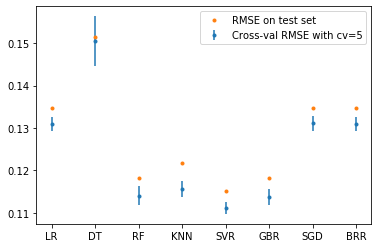

In [50]:
models = ["LR", "DT", "RF", "KNN", "SVR", "GBR", "SGD", "BRR"]
crossval_means = [LR_crossval_mean, DT_crossval_mean, RF_crossval_mean, KNN_crossval_mean, SVR_crossval_mean,
                 GBR_crossval_mean, SGD_crossval_mean, BRR_crossval_mean]
crossval_stds = [LR_crossval_std, DT_crossval_std, RF_crossval_std, KNN_crossval_std, SVR_crossval_std,
                 GBR_crossval_std, SGD_crossval_std, BRR_crossval_std]
test_rmses = [LR_test_rmse, DT_test_rmse, RF_test_rmse, KNN_test_rmse, SVR_test_rmse,
              GBR_test_rmse, SGD_test_rmse, BRR_test_rmse]
plt.errorbar(models, crossval_means, yerr=crossval_stds, fmt='.', label="Cross-val RMSE with cv=5")
plt.plot(models, test_rmses, '.', label="RMSE on test set")
plt.legend()

Very slight improvement but bigger standard deviation. We would still have the tendency to take the scaled inputs.

### 3. Random Forest B. Optimising hyperparameters

Running multiple times, itially got best params: max_features = 2 and n_estimators = 30 (which was the max value) and trying th grid search multiple times, we reached: max_features = 2 and n_estimators = 135

<ErrorbarContainer object of 3 artists>

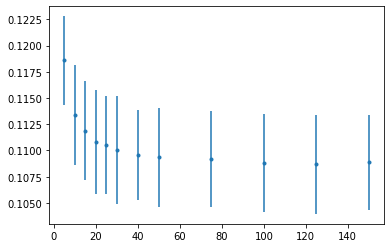

In [29]:
# USING SCALED VALUES
n_est = np.array([5, 10, 15, 20, 25, 30, 40, 50, 75, 100, 125, 150])
RF_crossval_rmse_mean = []
RF_crossval_rmse_std = []
for n in n_est:
    mean, std = model_crossval_errors(RandomForestRegressor(max_features = 2, n_estimators = n, 
                                                            random_state=42), 10, "scale")

    RF_crossval_rmse_mean = np.append(RF_crossval_rmse_mean, mean)
    RF_crossval_rmse_std = np.append(RF_crossval_rmse_std, std)
    
plt.errorbar(n_est, RF_crossval_rmse_mean, yerr = RF_crossval_rmse_std, fmt='.')

<ErrorbarContainer object of 3 artists>

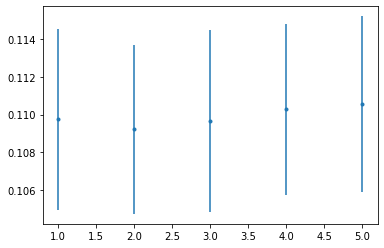

In [30]:
# USING SCALED VALUES
max_feat = np.array([1,2,3,4,5])
RF_crossval_rmse_mean = []
RF_crossval_rmse_std = []
for n in max_feat:
    mean, std = model_crossval_errors(RandomForestRegressor(max_features = n, n_estimators = 50,
                                                           random_state=42), 10, "scale")

    RF_crossval_rmse_mean = np.append(RF_crossval_rmse_mean, mean)
    RF_crossval_rmse_std = np.append(RF_crossval_rmse_std, std)
    
plt.errorbar(max_feat, RF_crossval_rmse_mean, yerr = RF_crossval_rmse_std, fmt='.')

On the scale of the standard deviations, the error from n_estimators = 50 is very close to the error from the larger n_estimators values. We will be choosing this value of n_estimators = 50 in the future to limit the number of steps and decrease processing time while having a fine-tuned model.

### 3. Random Forest C. Importance of the different filters

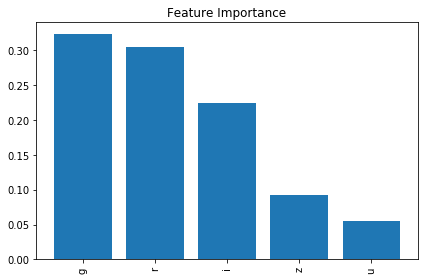

In [109]:
sorted_indices = np.argsort(feature_importances)[::-1]
feature_importances = np.array([0.05477891, 0.32373483, 0.30416697, 0.22426235, 0.09305694])
plt.title('Feature Importance')
plt.bar(range(x_train.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(x_train.shape[1]), x_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

### 3. Random Forest D. Attempting to vary redshift (and minimum magnitude)

<ErrorbarContainer object of 3 artists>

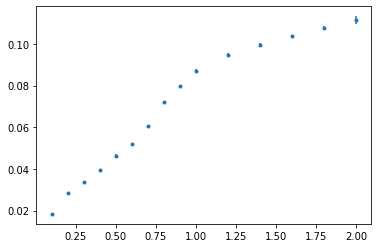

In [7]:
def model_crossval_errors(model, cv, x):
    if x=="scale":
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
        x_test_scaled = scaler.fit_transform(x_test.astype(np.float64))

        scores = cross_val_score(model, x_train_scaled, y_train,
                             scoring="neg_mean_squared_error", cv=cv)
        rmse_scores = np.sqrt(-scores)
        
    else:
        scores = cross_val_score(model, x_train, y_train,
                             scoring="neg_mean_squared_error", cv=cv)
        rmse_scores = np.sqrt(-scores)

    return rmse_scores.mean(), rmse_scores.std();

redshift_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
# just the maximum r value for now
r_values = [30]
RF_crossval_rmse_mean = []
RF_crossval_rmse_std = []

for max_redshift in redshift_values:
    for max_r in r_values:
        
        def get_train_test(max_redshift, max_r):
            # load
            df = pd.read_csv("star_classification.csv")
            # remove outliers
            # select the row with u or z or g below 0 (should not be allowed)
            outliers = df[(df["u"] <= 0)  
                        | (df["z"] <= 0) 
                        | (df["g"] <= 0)
                        | (df["redshift"] <= 0)
                        # GREAT improvement in predicting power when removing the >1 redshifts
                        | (df["redshift"] > max_redshift)
                        | (df["r"] > max_r)]

            # drop the row corresponding to the outlier
            df = df.drop(outliers.index, axis=0)

            # WE ONLY DEAL WITH GALAXIES HERE (see SDSS - 4 for correlations)
            df = df[df["class"] == "GALAXY"]

            # we drop the data we are not interested in and which won't be useful
            # expect isotropic universe -> could also drop position in sky
            df = df.drop(
                columns=["alpha", "delta", "obj_ID", "fiber_ID", "MJD", "plate", "spec_obj_ID", 
                         "field_ID", "cam_col", "rerun_ID", "run_ID", "class"], axis=1)

            df = df.replace([np.inf, -np.inf], np.nan)
            df = df.dropna(axis=0)

            return df
       
        df = get_train_test(max_redshift, max_r)
        df = df.reset_index(drop = True)

        redshift_cat_bins = np.linspace(0, max_redshift, 11)
        df["redshift_cat"] = pd.cut(df["redshift"],
                                    bins=redshift_cat_bins,
                                    labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
                                    # if only if redshift smaller than 1!
                                    #bins=[0., 0.2, 0.4, 0.6, 0.8, 1.0],
                                    #labels=[1, 2, 3, 4, 5])


        # stratified split
        split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

        for train_index, test_index in split.split(df, df["redshift_cat"]):
            strat_train_set = df.loc[train_index]
            strat_test_set = df.loc[test_index]

        # remove redshift category column
        for set_ in (strat_train_set, strat_test_set):
            set_.drop("redshift_cat", axis=1, inplace=True)

        x_train = strat_train_set.drop("redshift", axis=1)
        x_train = x_train.reset_index(drop = True)
        x_test = strat_test_set.drop("redshift", axis=1)
        x_test = x_test.reset_index(drop = True)

        y_train = strat_train_set["redshift"]
        y_train = y_train.reset_index(drop = True)
        y_test = strat_test_set["redshift"]
        y_test = y_test.reset_index(drop = True)
        
        mean, std = model_crossval_errors(RandomForestRegressor(max_features = 2, n_estimators = 50,
                                                               random_state=42), 2, "scale")
        RF_crossval_rmse_mean = np.append(RF_crossval_rmse_mean, mean)
        RF_crossval_rmse_std = np.append(RF_crossval_rmse_std, std)
        
plt.errorbar(redshift_values, RF_crossval_rmse_mean, yerr = RF_crossval_rmse_std, fmt='.')

<font color='red'>
Things to do:
 
1. random parameter search sur RF et comparer avec article
   
2. si differents, comparer les deux modeles sur mon dataset (voir si bonne generalisation sur DR17)
    
3. essayer peut-etre de manuellement (force brute) trouver parametres ideaux
    
4. similarily, essayer d'acceder DR12 et voir ma generalisation sur le dataset
</font>

### 3. Random Forest E. Random Hyperparameters Search 

In [16]:
param_grid = {'n_estimators': np.linspace(1,200,200).astype(int), 
               'max_features': np.linspace(1,5,5).astype(int),
               #'criterion': ['mse', 'mae'],
               'min_samples_split': np.linspace(2,100,99).astype(int),
               'min_samples_leaf': np.linspace(1,100,100).astype(int),
               'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4]}

forest_reg = RandomForestRegressor(random_state=42)

number_iterations = [10, 20, 30]

for n in number_iterations:
    start_time = time.time()
    random_search = RandomizedSearchCV(forest_reg, param_distributions=param_grid,
                                  cv = 3, n_iter = n)
    random_search.fit(x_train_scaled, y_train)
    print(random_search.best_params_)
    print("Time taken for random search with", n, " iterations: ", time.time() - start_time)


{'n_estimators': 66, 'min_weight_fraction_leaf': 0, 'min_samples_split': 73, 'min_samples_leaf': 64, 'max_features': 5}
Time taken for random search with 10  iterations:  203.1249234676361
{'n_estimators': 187, 'min_weight_fraction_leaf': 0, 'min_samples_split': 44, 'min_samples_leaf': 25, 'max_features': 3}
Time taken for random search with 20  iterations:  483.2149384021759
{'n_estimators': 89, 'min_weight_fraction_leaf': 0, 'min_samples_split': 22, 'min_samples_leaf': 38, 'max_features': 2}
Time taken for random search with 30  iterations:  246.7203652858734


In [20]:
param_grid = {'n_estimators': [50], 
               'max_features': [3],
               #'criterion': ['mse', 'mae'],
               'min_samples_split': [30,40,50],
               'min_samples_leaf': [25],
               'min_weight_fraction_leaf': [0]}

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(x_train_scaled, y_train)

grid_search.best_params_

{'max_features': 3,
 'min_samples_leaf': 25,
 'min_samples_split': 40,
 'min_weight_fraction_leaf': 0,
 'n_estimators': 50}

## Testing optimised models

## 1. Random Forest

{'max_features': 3, 'min_samples_leaf': 25, 'min_samples_split': 40,'min_weight_fraction_leaf': 0,'n_estimators': 50}

In [54]:
RF_test_rmse = model_fit_test(RandomForestRegressor(max_features=3, min_samples_leaf=25, min_samples_split=40,
                                                    min_weight_fraction_leaf=0,n_estimators=50,random_state=42))
print("RMSE on test set using fine tuned Random Forest Regressor:", RF_test_rmse)

RF_crossval_mean, RF_crossval_std = model_crossval_errors(RandomForestRegressor(max_features=3, 
                                                min_samples_leaf=25, min_samples_split=40,
                                                min_weight_fraction_leaf=0,n_estimators=50,random_state=42),5)
print("Average cross-validation RMSE using Random Forest Regressor:", RF_crossval_mean,
     "\nwith standard deviation:", RF_crossval_std)

RMSE on test set using fine tuned Random Forest Regressor: 0.11287084257818789
Average cross-validation RMSE using Random Forest Regressor: 0.10865080355054094 
with standard deviation: 0.00178082180985961


## 2. K-Nearest Neighbors

{'leaf_size': 1, 'n_neighbors': 20, 'p': 1}

In [64]:
param_grid = {'n_neighbors': [19,20,21],
               'p': [1,2],
               'leaf_size': [1]}

neigh = KNeighborsRegressor()

grid_search = GridSearchCV(neigh, param_grid, cv=3)

grid_search.fit(x_train_scaled, y_train)

grid_search.best_params_

{'leaf_size': 1, 'n_neighbors': 20, 'p': 1}

In [65]:
KNN_test_rmse = model_fit_test(KNeighborsRegressor(leaf_size=1, n_neighbors=20, p=1))
print("RMSE on test set using fine tuned KNN Regressor:", KNN_test_rmse)

KNN_crossval_mean, KNN_crossval_std = model_crossval_errors(KNeighborsRegressor(leaf_size=1, n_neighbors=20, p=1)
                                                          ,5)
print("Average cross-validation RMSE using KNN Regressor:", KNN_crossval_mean,
     "\nwith standard deviation:", KNN_crossval_std)

RMSE on test set using fine tuned KNN Regressor: 0.11556844649185197
Average cross-validation RMSE using KNN Regressor: 0.11160521448891958 
with standard deviation: 0.001785329424830891


## 3. Support Vector Regressor

{'C': 1.5, 'cache_size': 200, 'degree': 2, 'epsilon': 0.1}

In [67]:
param_grid = {'degree': [2,3,4], 
               'C': [1,1.5,2],
               'epsilon': [0.1],
               'cache_size': [200,250]}

sv_reg = SVR()

grid_search = GridSearchCV(sv_reg, param_grid, cv=3)

grid_search.fit(x_train_scaled, y_train)

grid_search.best_params_

{'C': 1.5, 'cache_size': 200, 'degree': 2, 'epsilon': 0.1}

In [69]:
SVR_test_rmse = model_fit_test(SVR(C=1.5, cache_size=200, degree=2, epsilon=0.1))
print("RMSE on test set using fine tuned Support Vector Regressor:", SVR_test_rmse)

SVR_crossval_mean, SVR_crossval_std = model_crossval_errors(SVR(C=1.5, cache_size=200, degree=2, epsilon=0.1)
                                                          ,5)
print("Average cross-validation RMSE using Support Vector Regressor:", SVR_crossval_mean,
     "\nwith standard deviation:", SVR_crossval_std)

RMSE on test set using fine tuned Support Vector Regressor: 0.11506325495362807
Average cross-validation RMSE using Support Vector Regressor: 0.11113890302966505 
with standard deviation: 0.001448113319343848


## 4. Gradient Boosting Regressor

Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance


In [80]:
param_grid = {'n_estimators': [50,100,150,200], 
               'learning_rate': [0.1,0.2,0.3,0.4,0.5],
               'min_samples_split': [2,25,50,75,100],
               'min_samples_leaf': [1,25,50,75,100],
               'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4],
               'subsample': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
               'max_features': [1,2,3,4,5],
               'alpha': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
               'max_depth': [1,2,3,4,5]}

GB_reg = GradientBoostingRegressor(random_state=42)

number_iterations = [10, 20, 30]

for n in number_iterations:
    start_time = time.time()
    random_search = RandomizedSearchCV(GB_reg, param_distributions=param_grid,
                                  cv = 3, n_iter = n)
    random_search.fit(x_train_scaled, y_train)
    print(random_search.best_params_)
    print("Time taken for random search with", n, " iterations: ", time.time() - start_time)

{'subsample': 0.6, 'n_estimators': 200, 'min_weight_fraction_leaf': 0.1, 'min_samples_split': 100, 'min_samples_leaf': 1, 'max_features': 2, 'max_depth': 5, 'learning_rate': 0.3, 'alpha': 0.9}
Time taken for random search with 10  iterations:  28.435109615325928
{'subsample': 0.9, 'n_estimators': 100, 'min_weight_fraction_leaf': 0, 'min_samples_split': 25, 'min_samples_leaf': 100, 'max_features': 2, 'max_depth': 5, 'learning_rate': 0.2, 'alpha': 0.1}
Time taken for random search with 20  iterations:  43.14496064186096
{'subsample': 0.9, 'n_estimators': 150, 'min_weight_fraction_leaf': 0, 'min_samples_split': 50, 'min_samples_leaf': 1, 'max_features': 1, 'max_depth': 4, 'learning_rate': 0.2, 'alpha': 0.2}
Time taken for random search with 30  iterations:  79.74619913101196


In [81]:
{'subsample': 0.8, 'n_estimators': 150, 'min_weight_fraction_leaf': 0, 
 'min_samples_split': 100, 'min_samples_leaf': 50, 'max_features': 2, 
 'max_depth': 4, 'learning_rate': 0.3, 'alpha': 0.3}

param_grid = {'n_estimators': [50,100,150,200], 
               'learning_rate': [0.1,0.2,0.3,0.4,0.5],
               'min_samples_split': [2,25,50,75,100],
               'min_samples_leaf': [1,25,50,75,100],
               'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4],
               'subsample': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
               'max_features': [1,2,3,4,5],
               'alpha': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
               'max_depth': [1,2,3,4,5]}

GB_reg = GradientBoostingRegressor(random_state=42)

number_iterations = [100, 200]

for n in number_iterations:
    start_time = time.time()
    random_search = RandomizedSearchCV(GB_reg, param_distributions=param_grid,
                                  cv = 3, n_iter = n)
    random_search.fit(x_train_scaled, y_train)
    print(random_search.best_params_)
    print("Time taken for random search with", n, " iterations: ", time.time() - start_time)

{'subsample': 0.8, 'n_estimators': 150, 'min_weight_fraction_leaf': 0, 'min_samples_split': 100, 'min_samples_leaf': 50, 'max_features': 2, 'max_depth': 4, 'learning_rate': 0.3, 'alpha': 0.3}
Time taken for random search with 100  iterations:  1059.6256692409515
{'subsample': 1, 'n_estimators': 100, 'min_weight_fraction_leaf': 0, 'min_samples_split': 75, 'min_samples_leaf': 25, 'max_features': 2, 'max_depth': 5, 'learning_rate': 0.1, 'alpha': 0.6}
Time taken for random search with 200  iterations:  1742.9782285690308


In [82]:
param_grid = {'n_estimators': [50], 
               'learning_rate': [0.2,0.3],
               'min_samples_split': [100],
               'min_samples_leaf': [25,50],
               'min_weight_fraction_leaf': [0],
               'subsample': [0.8],
               'max_features': [2,3],
               'alpha': [0.3,0.5],
               'max_depth': [4,5]}

GB_reg = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(GB_reg, param_grid, cv=3)

grid_search.fit(x_train_scaled, y_train)

grid_search.best_params_

{'alpha': 0.3,
 'learning_rate': 0.2,
 'max_depth': 5,
 'max_features': 3,
 'min_samples_leaf': 25,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0,
 'n_estimators': 50,
 'subsample': 0.8}

In [85]:
GBR_test_rmse = model_fit_test(GradientBoostingRegressor(alpha=0.3,learning_rate=0.2,max_depth=5,max_features=3,min_samples_leaf=25,min_samples_split=100,min_weight_fraction_leaf=0,n_estimators=50,subsample=0.8, random_state=42))
print("RMSE on test set using fine tuned Gradient Boosting Regressor:", GBR_test_rmse)

GBR_crossval_mean, GBR_crossval_std = model_crossval_errors(GradientBoostingRegressor(alpha=0.3,learning_rate=0.2,max_depth=5,max_features=3,min_samples_leaf=25,min_samples_split=100,min_weight_fraction_leaf=0,n_estimators=50,subsample=0.8, random_state=42)
                                                          ,5)
print("Average cross-validation RMSE using Gradient Boosted Regressor:", GBR_crossval_mean,
     "\nwith standard deviation:", GBR_crossval_std)

RMSE on test set using fine tuned Gradient Boosting Regressor: 0.11489842371767413
Average cross-validation RMSE using Gradient Boosted Regressor: 0.11085817260797477 
with standard deviation: 0.001871698943159269


**Trying baysian optimisation with optuna ... (FAIL)**

# !pip install --quiet optuna
import optuna 
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    """return the f1-score"""

    # search space
    n_estimators =  trial.suggest_int('n_estimators', low=100, high=200, step=50)
    criterion = trial.suggest_categorical('criterion', ['mse', 'mae'])
    min_samples_split = trial.suggest_int('min_samples_split', low=2, high=4, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', low=1, high=5, step=1)
    max_depth = trial.suggest_int('max_depth', low=5, high=7, step=1)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])

    # random forest classifier object
    rfc = RandomForestClassifier(n_estimators=n_estimators, 
                                 criterion=criterion,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_depth=max_depth, 
                                 max_features=max_features,
                                 random_state=42)
    
    score =  cross_val_score(estimator=rfc, 
                             X=x_train, 
                             y=y_train, 
                             scoring='f1_micro',
                             cv=5,
                             n_jobs=-1).mean()
    
    return score

# create a study (aim to maximize score)
study = optuna.create_study(sampler=TPESampler(), direction='maximize')

# perform hyperparamter tuning
study.optimize(objective, n_trials=100)

# store result in a data frame 
values_bayesian = [study.best_trial.number, study.best_trial.value]